In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SIM_STEPS = 201

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [3]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [4]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

In [5]:
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True,            # if True, mask is deterministic and noise is 0
                 future_delta=0
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask
        self.future_delta = future_delta

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    
    

    def __getitem__(self, index):
        
        # --- In Progress --- 

            # pick a valid step
        if not isinstance(self.steps, np.ndarray):
            max_start = SIM_STEPS - 1 - self.future_delta  # ensures step + delta ≤ 199
            step = np.random.randint(1, max_start + 1)  
        else:
            step = int(self.steps[index])
            max_start = SIM_STEPS - 1 - self.future_delta
            if step > max_start:
                step = max_start



        # if not type(self.steps) == np.ndarray:
        #     step = np.random.randint(1,200)
        # else:
        #     step = self.steps[index]



        # Create tensor for the target
        t_cur = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t_cur)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":

            # used for reveal_dim
            # map fraction [0,1] to pixel indices [0, N-1] in mask layer
            def _segments_to_indices(segments, N, pad=0):
                idxs = []
                for a, b in segments:
                    i0 = max(pad, int(round(a * (N - 1))))
                    i1 = min((N - 1) - pad, int(round(b * (N - 1))))
                    if i1 >= i0:
                        idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
                if not idxs:
                    # fallback to full range
                    return torch.arange(pad, N - pad, dtype=torch.long)
                return torch.unique(torch.cat(idxs)).to(torch.long)

            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1] # e.g, [(0, 1)]
            row_allowed = _segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = _segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio 
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))
            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))
            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)
            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]

            if not self.deterministic_mask:
                if self.jitter_std is not None and self.jitter_std > 0:
                    # convert std (like 0.01 of image size) to pixels
                    sigmaH = float(self.jitter_std) * self.H
                    sigmaW = float(self.jitter_std) * self.W
                    
                    # Add Gaussian noise in pixel units
                    ii = ii.to(torch.float32) + torch.randn_like(ii, dtype=torch.float32) * sigmaH
                    jj = jj.to(torch.float32) + torch.randn_like(jj, dtype=torch.float32) * sigmaW

                    # Round and clamp so they stay inside bounds
                    ii = ii.round().clamp(self.radius, self.H - 1 - self.radius).to(torch.long)
                    jj = jj.round().clamp(self.radius, self.W - 1 - self.radius).to(torch.long)




            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t_cur[chans].clone()
        # Add noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)


        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))








        # --- In Progress --- 

        if self.future_delta > 0:
            step_f = step + self.future_delta   
            t_label = torch.tensor(get_all(self.sims[index], step_f), dtype=torch.float32)
        else:
            t_label = t_cur.clone()



        if self.return_mask:
            return z,t_label, mask
        else:  
            return z,t_label
    
    def __len__(self):
        return self.sims.shape[0]


In [6]:
import numpy as np
import torch

def build_val_dataset_from_meta(meta):
    """
    Rebuilds the validation MaskedDataset exactly as used in training.
    Assumes you saved meta with keys like:
      - reveal_strategy, n_points, radius, noise, channels
      - val_steps, val_points
      - reveal_dim, deterministic_mask_val, jitter_std_val
      - mixed, future_delta
    """
    reveal_strategy   = str(meta["reveal_strategy"])
    n_points          = int(meta["n_points"])
    radius            = int(meta["radius"])
    noise             = float(meta["noise"])
    channels          = meta["channels"]
    val_steps         = meta["val_steps"]
    val_points        = meta["val_points"]
    reveal_dim        = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask= bool(meta["deterministic_mask_val"])
    jitter_std        = float(meta["jitter_std_val"])
    mixed             = bool(meta["mixed"])
    future_delta      = int(meta["future_delta"]) if "future_delta" in meta.files else 0

    # match plotting/val reproducibility
    torch.manual_seed(123); np.random.seed(123)

    val_data = MaskedDataset(
        val_sims,
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=val_points,
        steps=val_steps,
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )
    return val_data, val_steps, future_delta

In [7]:
import numpy as np
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_mse_for_model(name, batch_size=16):
    """
    Loads meta + model for `name`, rebuilds val dataset, and computes global MSE.
    Assumes:
      - meta file:  f"meta_{name}.npz"
      - model file: f"{name}.pt"
      - build_val_dataset_from_meta(meta) is defined
      - val_sims, MaskedDataset are available
    """
    # --- load meta & rebuild dataset ---
    meta = np.load(f"meta_{name}.npz", allow_pickle=True)
    val_data, val_steps, future_delta = build_val_dataset_from_meta(meta)

    # --- wrap in DataLoader ---
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # --- load model ---
    model = torch.load(f"{name}.pt", map_location=device)
    model.eval()

    se_sum = 0.0
    n_elem = 0

    with torch.no_grad():
        for feat, label in val_loader:
            feat  = feat.to(device)
            label = label.to(device)

            pred = model(feat)
            se   = (pred - label) ** 2

            se_sum += se.sum().item()
            n_elem += se.numel()

    mse = se_sum / max(1, n_elem)
    return mse

In [8]:
def make_sample_for_sim_time(sim_id, t, meta, future_delta):
    """
    Build a single (z, t_label) pair for a specific sim and time t
    using the same config that was used during training.
    """
    reveal_strategy    = str(meta["reveal_strategy"])
    n_points           = int(meta["n_points"])
    radius             = int(meta["radius"])
    noise              = float(meta["noise"])
    channels           = meta["channels"]
    reveal_dim         = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask = bool(meta["deterministic_mask_val"])
    jitter_std         = float(meta["jitter_std_val"])
    mixed              = bool(meta["mixed"])

    # make sure t is valid for this delta
    SIM_STEPS = 201
    max_start = SIM_STEPS - 1 - future_delta   # same logic as in MaskedDataset
    t = min(int(t), max_start)

    ds = MaskedDataset(
        sims=np.array([sim_id]),
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=None,                         # let it pick mask positions
        steps=np.array([t]),                 # <- force time t
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )

    z, t_label = ds[0]   # only one sample
    return z, t_label, t

In [9]:
vals = range(140)
deltas_darcy = list(vals[::2])
deltas_nodarcy = list(vals[::6])

tests_darcy = [
    {
        "name": f"full_d{d}_n16_clean",
        "reveal_strategy": "disks",
        "n_points": 16,
        "radius": 5,
        "mixed": False,
        "noise": 0, 
        "deterministic_mask": False,
        "jitter_std": 0.02,
        "reveal_dim": [[(0.2, .8)],[(.2,.8)]],
        "future_delta": d,
    }
    for d in deltas_darcy
]

tests_no_darcy = [
    {
        "name": f"full_d{d}_n16_noDarcy",
        "reveal_strategy": "disks",
        "n_points": 16,
        "radius": 5,
        "mixed": False,
        "noise": 0, 
        "deterministic_mask": False,
        "jitter_std": 0.02,
        "reveal_dim": [[(0.2, .8)],[(.2,.8)]],
        "future_delta": d,
    }
    for d in deltas_nodarcy
]


tests = tests_darcy + tests_no_darcy

Global error vs Δ curve

In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.serialization import add_safe_globals
add_safe_globals([SmallUnet])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# allowlist your model class so torch.load can unpickle it
add_safe_globals([SmallUnet])

def eval_mse_for_model(name, batch_size=16):
    """
    Loads meta + model for `name`, rebuilds val dataset, and computes global MSE.
    Assumes:
      - meta file:  f"meta_{name}.npz"
      - model file: f"{name}.pt"
      - build_val_dataset_from_meta(meta) is defined
      - val_sims, MaskedDataset are available
    """
    # --- load meta & rebuild dataset ---
    meta = np.load(f"meta_{name}.npz", allow_pickle=True)
    val_data, val_steps, future_delta = build_val_dataset_from_meta(meta)

    # --- wrap in DataLoader ---
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # --- load model (full object, not weights_only) ---
    model = torch.load(
        f"{name}.pt",
        map_location=device,
        weights_only=False,   # IMPORTANT for old-style full-model checkpoints
    )
    model.eval()

    se_sum = 0.0
    n_elem = 0

    with torch.no_grad():
        for feat, label in val_loader:
            feat  = feat.to(device)
            label = label.to(device)

            pred = model(feat)
            se   = (pred - label) ** 2

            se_sum += se.sum().item()
            n_elem += se.numel()

    mse = se_sum / max(1, n_elem)
    return mse

In [14]:
mse_darcy   = []
used_darcy  = []  # in case some models/meta are missing

for d in deltas_darcy:
    name = f"full_d{d}_n16_clean"   # change if your naming is different
    try:
        mse = eval_mse_for_model(name)
        mse_darcy.append(mse)
        used_darcy.append(d)
        print(f"[Darcy] Δ={d:3d}, MSE={mse:.5f}")
    except FileNotFoundError:
        print(f"[Darcy] Skipping {name}: missing model or meta file")

[Darcy] Δ=  0, MSE=90.32197
[Darcy] Δ=  2, MSE=230.90692
[Darcy] Δ=  4, MSE=240.43563
[Darcy] Δ=  6, MSE=801.02451
[Darcy] Δ=  8, MSE=115.67225
[Darcy] Δ= 10, MSE=301.92158
[Darcy] Δ= 12, MSE=1039.43096
[Darcy] Δ= 14, MSE=191.35509
[Darcy] Δ= 16, MSE=1728.65569
[Darcy] Δ= 18, MSE=749.13730
[Darcy] Δ= 20, MSE=847.17558
[Darcy] Δ= 22, MSE=211.74895
[Darcy] Δ= 24, MSE=282.99550
[Darcy] Δ= 26, MSE=215.38845
[Darcy] Δ= 28, MSE=164.73158
[Darcy] Δ= 30, MSE=2699.25485
[Darcy] Δ= 32, MSE=236.08832
[Darcy] Δ= 34, MSE=9249.47091
[Darcy] Δ= 36, MSE=288.60459
[Darcy] Δ= 38, MSE=2179.94141
[Darcy] Δ= 40, MSE=166.93487
[Darcy] Δ= 42, MSE=299.64741
[Darcy] Δ= 44, MSE=213.48016
[Darcy] Δ= 46, MSE=231.81390
[Darcy] Δ= 48, MSE=2454.65958
[Darcy] Δ= 50, MSE=284.66110
[Darcy] Δ= 52, MSE=191.53880
[Darcy] Δ= 54, MSE=200.63272
[Darcy] Δ= 56, MSE=331.15981
[Darcy] Δ= 58, MSE=217.70966
[Darcy] Δ= 60, MSE=275.94302
[Darcy] Δ= 62, MSE=3791.61633
[Darcy] Δ= 64, MSE=2279.07764
[Darcy] Δ= 66, MSE=37922.07644
[Darc

In [15]:
mse_nodarcy  = []
used_nodarcy = []

for d in deltas_nodarcy:
    # If you named them differently, edit here:
    # e.g. name = f"nodarcy_d{d}_n16_clean"
    name = f"full_d{d}_n16_noDarcy"

    try:
        mse = eval_mse_for_model(name)
        mse_nodarcy.append(mse)
        used_nodarcy.append(d)
        print(f"[No Darcy] Δ={d:3d}, MSE={mse:.5f}")
    except FileNotFoundError:
        print(f"[No Darcy] Skipping {name}: missing model or meta file")

[No Darcy] Δ=  0, MSE=79.73080
[No Darcy] Δ=  6, MSE=122.98658
[No Darcy] Δ= 12, MSE=642.60895
[No Darcy] Δ= 18, MSE=102.96188
[No Darcy] Δ= 24, MSE=143.22834
[No Darcy] Δ= 30, MSE=140.26054
[No Darcy] Δ= 36, MSE=1086.81179
[No Darcy] Δ= 42, MSE=149.53416
[No Darcy] Δ= 48, MSE=862.59846
[No Darcy] Δ= 54, MSE=306.29159
[No Darcy] Δ= 60, MSE=180.24111
[No Darcy] Δ= 66, MSE=1453.54790
[No Darcy] Δ= 72, MSE=593.25693
[No Darcy] Δ= 78, MSE=250.48244
[No Darcy] Δ= 84, MSE=244.59534
[No Darcy] Δ= 90, MSE=2314.51920
[No Darcy] Skipping full_d96_n16_noDarcy: missing model or meta file
[No Darcy] Skipping full_d102_n16_noDarcy: missing model or meta file
[No Darcy] Skipping full_d108_n16_noDarcy: missing model or meta file
[No Darcy] Skipping full_d114_n16_noDarcy: missing model or meta file
[No Darcy] Skipping full_d120_n16_noDarcy: missing model or meta file
[No Darcy] Skipping full_d126_n16_noDarcy: missing model or meta file
[No Darcy] Skipping full_d132_n16_noDarcy: missing model or meta fi

In [38]:
print(mse_darcy)
print(mse_darcy[33])
new_mse_darcy = []
new_used_darcy = []
for i in range(len(mse_darcy)):
    if i == 33:
        continue
    if mse_darcy[i] >= 1500:
        continue
    new_mse_darcy.append(mse_darcy[i])
    new_used_darcy.append(used_darcy[i])

print(new_mse_darcy)

[90.32196798245614, 230.9069187134503, 240.435633625731, 801.0245064327486, 115.67225116959064, 301.9215760233918, 1039.4309590643275, 191.35508684210527, 1728.6556865497075, 749.1372994152047, 847.1755847953216, 211.74894678362574, 282.9955, 215.38845307017544, 164.73157631578948, 2699.254849122807, 236.088316374269, 9249.470914619884, 288.60459298245615, 2179.941410526316, 166.93486929824562, 299.64740701754386, 213.48016315789474, 231.8138985380117, 2454.6595789473686, 284.661098245614, 191.538799122807, 200.63272309941522, 331.1598081871345, 217.70965789473684, 275.94302134502925, 3791.6163321637428, 2279.0776421052633, 37922.07644444444, 209.17515, 2197.1701894736843, 302.7246081871345, 2416.657705263158, 1440.8476467836258, 2327.9929450292398, 1302.9418736842106, 276.0777073099415, 1115.1941497076023, 270.6831520467836, 1334.052898245614, 272.20284444444445, 2235.4615859649125, 981.2629076023392, 828.3746830409357, 1089.9725590643275, 566.6231005847953, 327.6641374269006, 674.988

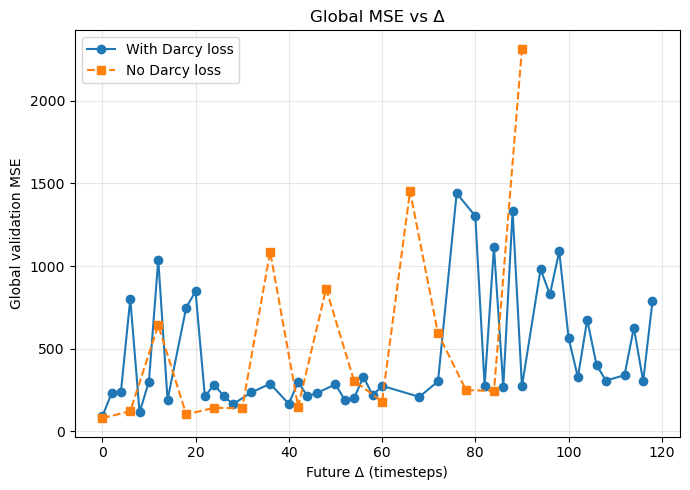

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

if mse_darcy:
    plt.plot(new_used_darcy, new_mse_darcy, marker="o", linestyle="-", label="With Darcy loss")

if mse_nodarcy:
    plt.plot(used_nodarcy, mse_nodarcy, marker="s", linestyle="--", label="No Darcy loss")

plt.xlabel("Future Δ (timesteps)")
plt.ylabel("Global validation MSE")
plt.title("Global MSE vs Δ")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Direction Prediction

In [17]:
def make_sample_for_sim_time(sim_id, t, meta, future_delta):
    """
    Build a single (z, t_label) pair for a specific sim and time t
    using the same config that was used during training.
    """
    reveal_strategy    = str(meta["reveal_strategy"])
    n_points           = int(meta["n_points"])
    radius             = int(meta["radius"])
    noise              = float(meta["noise"])
    channels           = meta["channels"]
    reveal_dim         = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask = bool(meta["deterministic_mask_val"])
    jitter_std         = float(meta["jitter_std_val"])
    mixed              = bool(meta["mixed"])

    # make sure t is valid for this delta
    SIM_STEPS = 201
    max_start = SIM_STEPS - 1 - future_delta   # same logic as in MaskedDataset
    t = min(int(t), max_start)

    ds = MaskedDataset(
        sims=np.array([sim_id]),
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=None,                         # let it pick mask positions
        steps=np.array([t]),                 # <- force time t
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )

    z, t_label = ds[0]   # only one sample
    return z, t_label, t

In [18]:
import numpy as np
import torch

def side_from_image(img, channel=0, top_rows=40, min_mass=1e-3):
    """
    Decide whether the channel is more on the left or right in the top part
    of the image.

    img: (C, H, W) numpy array or torch tensor
    channel: which channel to look at (0=K, 1=P, 2=phi)
    top_rows: only look at rows [0:top_rows] to focus on the inlet region
    min_mass: if total intensity is below this, treat as 'too weak'
    """
    if torch.is_tensor(img):
        arr = img.detach().cpu().numpy()
    else:
        arr = np.asarray(img)

    C, H, W = arr.shape
    top_rows = min(top_rows, H)

    patch = arr[channel, :top_rows, :]          # (top_rows, W)

    left_mass  = patch[:, :W//2].sum()
    right_mass = patch[:, W//2:].sum()
    total      = left_mass + right_mass

    if total < min_mass:
        # essentially no channel signal -> skip
        return None, 0.0, total

    margin = abs(left_mass - right_mass) / max(total, 1e-8)
    side   = "L" if left_mass > right_mass else "R"

    return side, margin, total

In [19]:
import numpy as np
import torch

def left_right_accuracy_over_time(
    model_name,
    base_path="",
    future_delta=None,        # if None, read from meta
    time_values=None,         # list of times t to evaluate
    channel=0,                # 0=K, 1=P, 2=phi (for deciding side)
    top_rows=40,
    min_mass=1e-3,
    strong_margin=0.10,       # margin threshold for “strong GT”
    max_sims=None,            # limit sims for speed
    verbose=True,
):
    """
    For a single trained model, compute directional accuracy (left vs right)
    as a function of the start time t.

    Returns a dict with:
      - times, acc_all, acc_strong, n_all, n_strong,
        n_lowmass, n_ambig, future_delta
    """

    meta_path  = f"{base_path}meta_{model_name}.npz"
    model_path = f"{base_path}{model_name}.pt"

    meta  = np.load(meta_path, allow_pickle=True)

    # Load full model object (PyTorch 2.6+)
    model = torch.load(
        model_path,
        map_location=device,
        weights_only=False,
    ).to(device)
    model.eval()

    # get Δ
    if future_delta is None:
        future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else 0

    # which sims to use
    sims = np.array(val_sims, copy=True)
    if max_sims is not None:
        sims = sims[:max_sims]

    # default time grid if not given
    if time_values is None:
        time_values = list(range(60, 141, 5))

    results = {
        "times": [],
        "acc_all": [],
        "acc_strong": [],
        "n_all": [],
        "n_strong": [],
        "n_lowmass": [],
        "n_ambig": [],
        "future_delta": future_delta,
        "model_name": model_name,
    }

    for t in time_values:
        # skip times whose future t+Δ goes past the end
        if t + future_delta >= SIM_STEPS:
            continue

        correct_all = total_all = 0
        correct_str = total_str = 0
        n_lowmass = 0
        n_ambig   = 0

        for sim_id in sims:
            sim_id = int(sim_id)

            # build masked input at time t using your same meta config
            z, t_label, t_actual = make_sample_for_sim_time(sim_id, t, meta, future_delta)

            t_f = t + future_delta

            # GT future
            img_true_future = get_all(sim_id, t_f)    # (3, H, W)

            # model prediction
            with torch.no_grad():
                out = model(z.to(device).unsqueeze(0))[0]
            img_pred_future = out.detach().cpu().numpy()  # (3, H, W)

            # ---- decide L/R for GT ----
            side_true, margin_true, mass_true = side_from_image(
                img_true_future,
                channel=channel,
                top_rows=top_rows,
                min_mass=min_mass,
            )

            if side_true is None:
                # essentially no signal
                n_lowmass += 1
                continue

            # ---- decide L/R for prediction ----
            side_pred, margin_pred, mass_pred = side_from_image(
                img_pred_future,
                channel=channel,
                top_rows=top_rows,
                min_mass=min_mass,
            )

            if side_pred is None:
                # no meaningful prediction -> counts as trial, incorrect
                total_all += 1
                if margin_true >= strong_margin:
                    total_str += 1
                continue

            is_strong = (margin_true >= strong_margin)

            total_all += 1
            if side_pred == side_true:
                correct_all += 1

            if is_strong:
                total_str += 1
                if side_pred == side_true:
                    correct_str += 1
            else:
                n_ambig += 1

        acc_all = np.nan if total_all == 0 else correct_all / total_all
        acc_str = np.nan if total_str == 0 else correct_str / total_str

        results["times"].append(t)
        results["acc_all"].append(acc_all)
        results["acc_strong"].append(acc_str)
        results["n_all"].append(total_all)
        results["n_strong"].append(total_str)
        results["n_lowmass"].append(n_lowmass)
        results["n_ambig"].append(n_ambig)

        if verbose:
            print(
                f"[{model_name}] t={t:3d}, Δ={future_delta:3d} | "
                f"acc_all={acc_all:.3f} (n={total_all}), "
                f"acc_strong={acc_str:.3f} (n_str={total_str}), "
                f"lowmass={n_lowmass}, ambig={n_ambig}"
            )

    return results

In [21]:
import os

all_dir__nd_results = {}   # model_name -> result dict

for cfg in tests_no_darcy:
    name = cfg["name"]
    Δ    = cfg["future_delta"]

    model_path = f"{name}.pt"
    meta_path  = f"meta_{name}.npz"

    if not os.path.exists(model_path):
        print(f"🚫 Skipping {name} — model file not found ({model_path})")
        continue
    if not os.path.exists(meta_path):
        print(f"🚫 Skipping {name} — meta file not found ({meta_path})")
        continue

    if Δ <= 10:
        time_grid = list(range(80, 121, 5))   # short-horizon
    elif Δ <= 40:
        time_grid = list(range(60, 121, 5))   # medium-horizon
    else:
        time_grid = list(range(30, 121, 5))   # long-horizon

    print(f"➡ Evaluating {name} (Δ={Δ}) over times {time_grid}...")

    res = left_right_accuracy_over_time(
        name,
        base_path="",
        future_delta=Δ,        # or None to read from meta
        time_values=time_grid,
        channel=0,
        top_rows=40,
        strong_margin=0.10,
        max_sims=250,
        verbose=False,         # <--- turn off per-t spam
    )

    all_dir__nd_results[name] = res
    print(f"Done {name}, Δ={Δ}, mean acc_all={np.nanmean(res['acc_all']):.3f}")
    print("-" * 50)

➡ Evaluating full_d0_n16_noDarcy (Δ=0) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d0_n16_noDarcy, Δ=0, mean acc_all=0.891
--------------------------------------------------
➡ Evaluating full_d6_n16_noDarcy (Δ=6) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d6_n16_noDarcy, Δ=6, mean acc_all=0.708
--------------------------------------------------
➡ Evaluating full_d12_n16_noDarcy (Δ=12) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d12_n16_noDarcy, Δ=12, mean acc_all=0.729
--------------------------------------------------
➡ Evaluating full_d18_n16_noDarcy (Δ=18) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d18_n16_noDarcy, Δ=18, mean acc_all=0.893
--------------------------------------------------
➡ Evaluating full_d24_n16_noDarcy (Δ=24) over times [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d24_n16_noDarcy, Δ=24, mean acc_all=0.810
-----------

In [22]:
import os

all_dir_results = {}   # model_name -> result dict

for cfg in tests:
    name = cfg["name"]
    Δ    = cfg["future_delta"]

    model_path = f"{name}.pt"
    meta_path  = f"meta_{name}.npz"

    if not os.path.exists(model_path):
        print(f"🚫 Skipping {name} — model file not found ({model_path})")
        continue
    if not os.path.exists(meta_path):
        print(f"🚫 Skipping {name} — meta file not found ({meta_path})")
        continue

    if Δ <= 10:
        time_grid = list(range(80, 121, 5))   # short-horizon
    elif Δ <= 40:
        time_grid = list(range(60, 121, 5))   # medium-horizon
    else:
        time_grid = list(range(30, 121, 5))   # long-horizon

    print(f"➡ Evaluating {name} (Δ={Δ}) over times {time_grid}...")

    res = left_right_accuracy_over_time(
        name,
        base_path="",
        future_delta=Δ,        # or None to read from meta
        time_values=time_grid,
        channel=0,
        top_rows=40,
        strong_margin=0.10,
        max_sims=250,
        verbose=False,         # <--- turn off per-t spam
    )

    all_dir_results[name] = res
    print(f"Done {name}, Δ={Δ}, mean acc_all={np.nanmean(res['acc_all']):.3f}")
    print("-" * 50)

➡ Evaluating full_d0_n16_clean (Δ=0) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d0_n16_clean, Δ=0, mean acc_all=0.915
--------------------------------------------------
➡ Evaluating full_d2_n16_clean (Δ=2) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d2_n16_clean, Δ=2, mean acc_all=0.912
--------------------------------------------------
➡ Evaluating full_d4_n16_clean (Δ=4) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d4_n16_clean, Δ=4, mean acc_all=0.778
--------------------------------------------------
➡ Evaluating full_d6_n16_clean (Δ=6) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d6_n16_clean, Δ=6, mean acc_all=0.442
--------------------------------------------------
➡ Evaluating full_d8_n16_clean (Δ=8) over times [80, 85, 90, 95, 100, 105, 110, 115, 120]...
Done full_d8_n16_clean, Δ=8, mean acc_all=0.942
--------------------------------------------------
➡ Evaluating full_d10_n16_clean (Δ=10) o

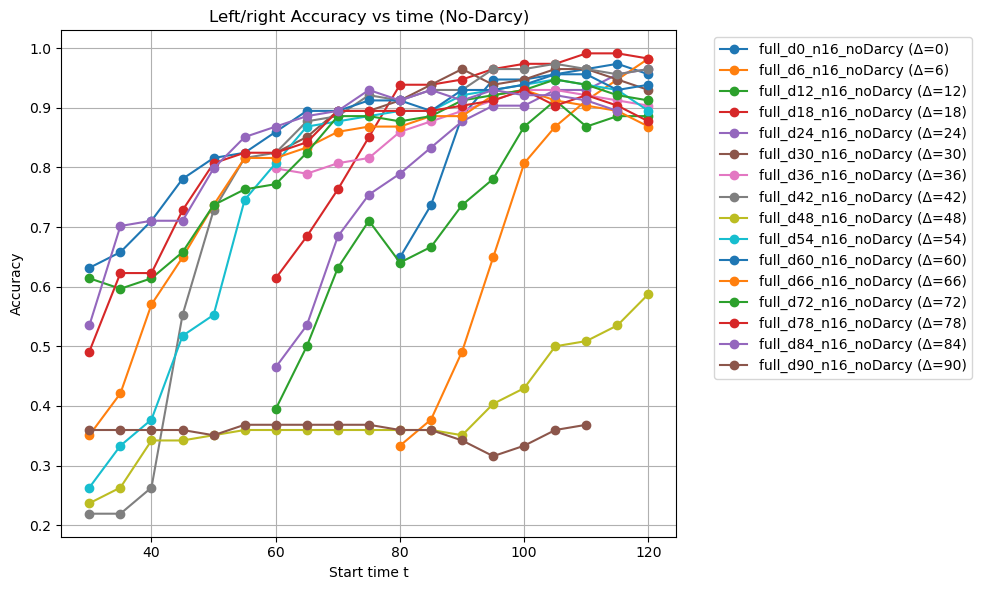

C:\Users\jaden\AppData\Local\Temp\ipykernel_5648\2648947795.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


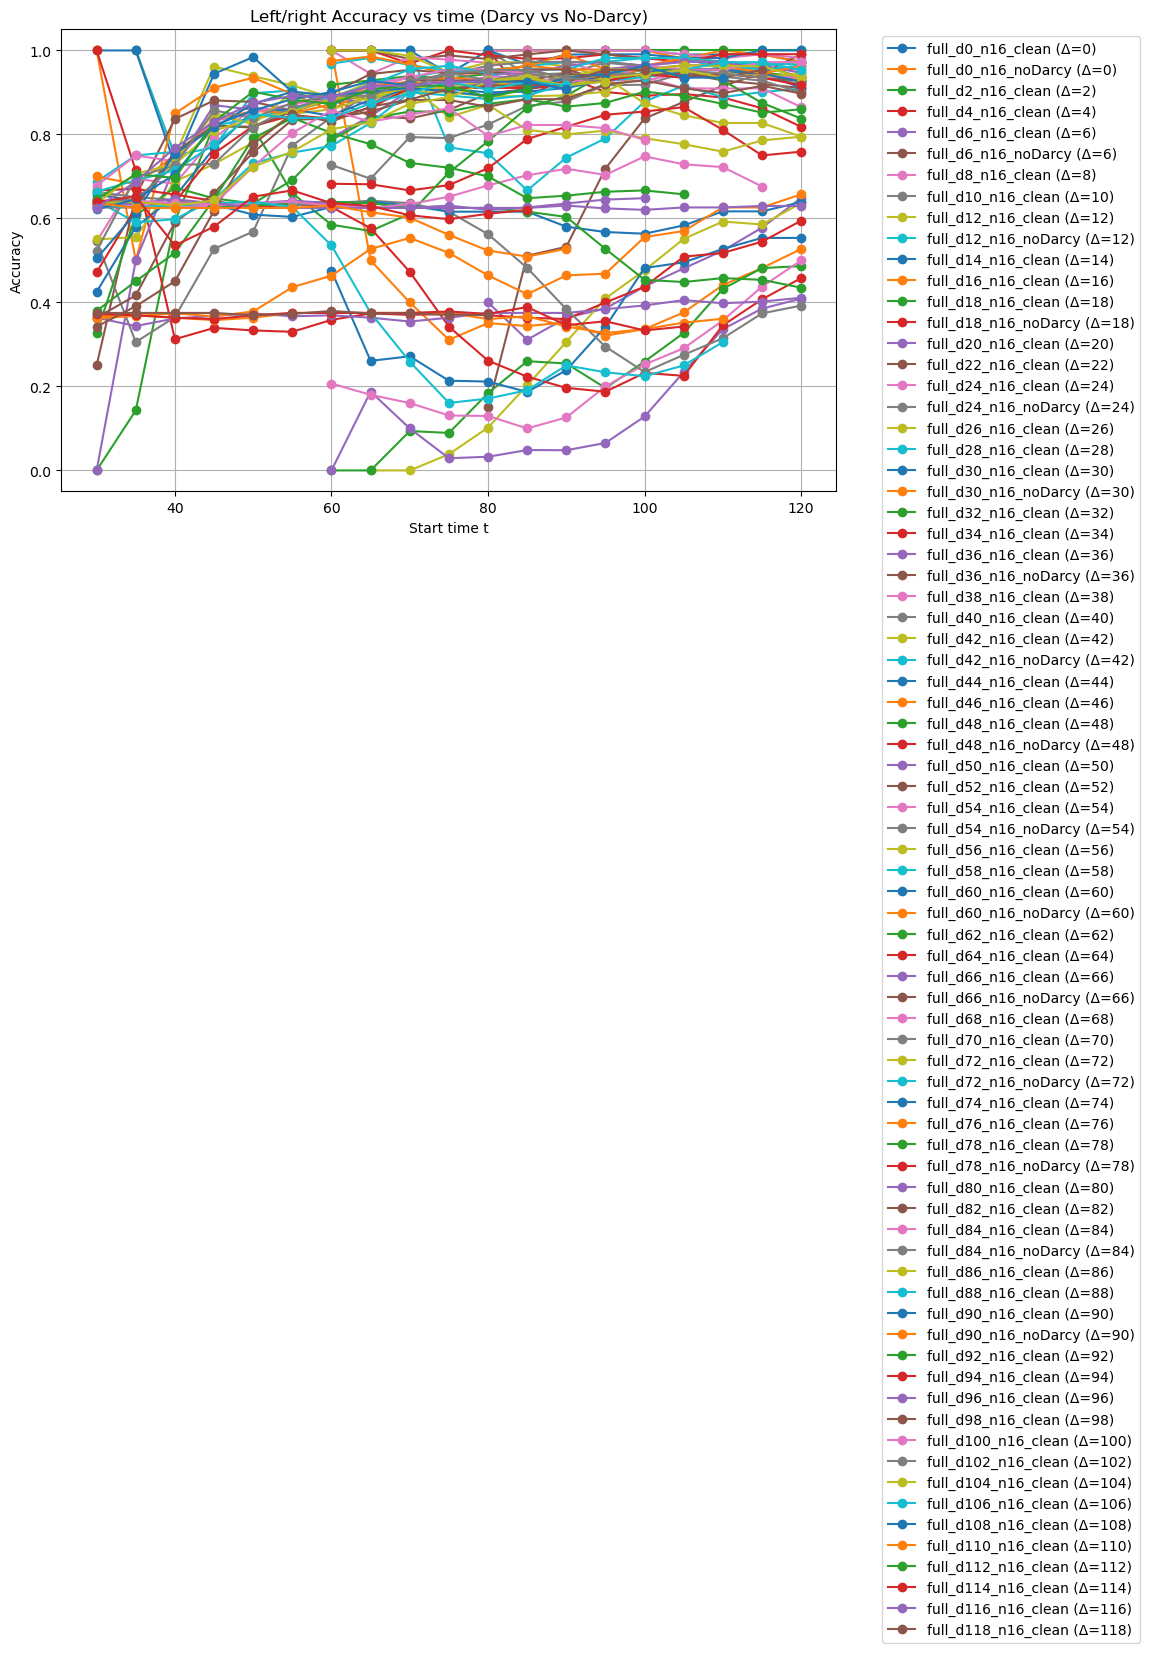

In [40]:
import matplotlib.pyplot as plt

def plot_direction_accuracy(all_results, which="acc_all", title_suffix=""):
    """
    all_results: dict model_name -> result dict returned by left_right_accuracy_over_time
    which: "acc_all" or "acc_strong"
    """
    plt.figure(figsize=(10, 6))

    # Sort by Δ for nicer legend ordering
    items = sorted(
        all_results.items(),
        key=lambda kv: kv[1]["future_delta"]
    )

    for model_name, res in items:
        times = res["times"]
        vals  = res[which]
        Δ     = res["future_delta"]
        plt.plot(times, vals, marker="o", label=f"{model_name} (Δ={Δ})")

    plt.xlabel("Start time t")
    ylabel = "Accuracy" if which == "acc_all" else "Accuracy"
    plt.ylabel(ylabel)
    plt.title(f"Left/right {ylabel} vs time {title_suffix}")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
    plt.tight_layout()
    plt.show()

# Example:
plot_direction_accuracy(all_dir__nd_results, which="acc_all",   title_suffix="(No-Darcy)")
plot_direction_accuracy(all_dir_results, which="acc_strong",title_suffix="(Darcy vs No-Darcy)")
